In [ ]:
!pip install pandas==2.2.2 numpy==1.26.4 pandas-ta==0.3.14b0 --force-reinstall --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 20.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
import pandas as pd
import yfinance as yf
from datetime import datetime
import numpy as np
import tensorflow as tf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
from sklearn.preprocessing import LabelEncoder

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Historical Technical Analysis - Data Importing/Preprocessing**

In [2]:
from os import rename
from datetime import date

TODAY = date.today().strftime("%Y-%m-%d")
START = datetime(2002, 1, 9)

df = yf.download('AAPL', START, TODAY)
df.columns = df.columns.droplevel(1)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df["Future_Price"] = df["Close"].shift(-1)
df['Close_Lag1'] = df['Close'].shift(1)
df['Close_Lag2'] = df['Close'].shift(2)
df.tail()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume,Future_Price,Close_Lag1,Close_Lag2
Date,,,,,,,,
2025-04-09,198.850006,200.610001,171.889999,171.949997,184395900,190.419998,172.419998,181.460007
2025-04-10,190.419998,194.779999,183.000000,189.070007,121880000,198.149994,198.850006,172.419998
2025-04-11,198.149994,199.539993,186.059998,186.100006,87435900,202.520004,190.419998,198.850006
2025-04-14,202.520004,212.940002,201.160004,211.440002,101352900,202.139999,198.149994,190.419998
2025-04-15,202.139999,203.509995,199.800003,201.860001,51103200,NaN,202.520004,198.149994


# **Feature Engineering - Technical Financial Indicators**

In [3]:
# Trend Indicators
df['SMA_20'] = ta.sma(df['Close'], length=20) # 20-day SMA (short-term trend)
df['EMA_50'] = ta.ema(df['Close'], length=50) # Exponential Moving Average (50 days) - faster response to price changes

# Momentum Indicators
df['RSI_14'] = ta.rsi(df['Close'], length=14) # Measures momentum & overbought/oversold levels
df['STOCH_K'] = ta.stoch(df['High'], df['Low'], df['Close'])['STOCHk_14_3_3']  # Stochastic Oscillator %K - short-term momentum

# Volatility Indicators
df['ATR_14'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)
df['BB_percent'] = ta.bbands(df['Close'], length=20)['BBP_20_2.0']

# Volume Indicators
df['OBV'] = ta.obv(df['Close'], df['Volume'])  # On-Balance Volume - volume flow relative to price direction
df['Volume_pct_change'] = df['Volume'].pct_change()  # Daily % change in volume - signals volume spikes/drops

# Price-Based Features
df['Return_1d'] = df['Close'].pct_change()  # Daily return - raw price momentum

# Custom Signal
df['Breakout_SMA20'] = (df['Close'] > df['SMA_20']).astype(int)  # Binary flag if price is above short-term trend

# MACD - Trend + Momentum combo indicator
macd = ta.macd(df['Close'])
df['MACD_Line'] = macd['MACD_12_26_9']  # Difference between 12-EMA and 26-EMA - trend momentum
df['MACD_Signal'] = macd['MACDs_12_26_9']  # 9-day EMA of MACD_Line - signal for crossovers (entry/exit)

df.drop(columns=['High', 'Low', 'Open'], inplace=True)
df.dropna(inplace=True)

# Build model using XGBoost

In [4]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.4 MB/s eta 0:00:00


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel
import numpy as np
from itertools import product
import optuna

# Columns to exclude (poorly affecting the model)
DROP_COLS = ['Close', 'Target', 'Close_Lag2','Future_Price', 'Close_Lag1']

# Additional feature Engineering
def create_features(df):
    df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
    df['Return_1d_5d_avg'] = df['Return_1d'].rolling(5).mean() # Avg return over past 5 days
    df['OBV_lag1'] = df['OBV'].shift(1) # Lagged OBV - tracks volume trend from the previous day
    df['RSI_lag1'] = df['RSI_14'].shift(1) # Lagged RSI
    df['MACD_crossover'] = (df['MACD_Line'] > df['MACD_Signal']).astype(int) # if MACD line is above signal line = bullish momentum, else common buy signal
    df['Vol_Return_Interaction'] = df['Volume_pct_change'] * df['Return_1d'] # Interaction term - captures price movement strength with volume confirmation
    df['ATR_spike'] = (df['ATR_14'] > df['ATR_14'].rolling(5).mean()).astype(int) # Volatility spike flag
    df['Bullish_Trend'] = (df['SMA_20'] > df['EMA_50']).astype(int) # Short > long = bullish signal
    return df

# Apply target filter for only meaningful price changes
def apply_target_filter(df, threshold=0.005):
    df_cleaned = df.dropna().copy()
    df_cleaned['Target'] = np.where(
        df_cleaned['Return_1d'].shift(-1) > threshold, 1,
        np.where(df_cleaned['Return_1d'].shift(-1) < -threshold, 0, np.nan)
    )
    df_cleaned.dropna(subset=['Target'], inplace=True)
    df_cleaned['Target'] = df_cleaned['Target'].astype(int)
    return df_cleaned

# Optuna XGBoost Training
def train_xgb_with_optuna(df_subset, regime_name, n_trials=30):
    print(f"\nTraining Optuna on {regime_name} regime ({len(df_subset)} samples)")

    features = df_subset.drop(columns=DROP_COLS)
    X = features.values
    y = df_subset['Target'].values
    tscv = TimeSeriesSplit(n_splits=5) # Time-series aware CV

    # Define Optuna's objective function for hyperparameter tuning
    def objective(trial):

        # Define hyperparameter search space
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_int('gamma', 0, 5),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
            'eval_metric': 'logloss',
            'random_state': 42
        }

        fs_threshold = trial.suggest_categorical("fs_threshold", ["mean", "median", 0.1, 0.2])
        fold_accuracies = []

        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            model = xgb.XGBClassifier(**params)
            model.fit(X_train, y_train)

            # Skip if too few features remain
            if selector.transform(X_train).shape[1] < 2:
                return 0.0

            X_train_sel = selector.transform(X_train)
            X_test_sel = selector.transform(X_test)

            model.fit(X_train_sel, y_train)
            y_pred = model.predict(X_test_sel)
            acc = accuracy_score(y_test, y_pred)
            fold_accuracies.append(acc)

        return np.mean(fold_accuracies)

    # Optuna Optimization
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    print(f"\nBest trial for {regime_name}: {study.best_trial.params}")
    print(f"Best Accuracy: {study.best_value:.4f}")

    # Final model fit
    best_params = study.best_trial.params.copy()
    fs_threshold = best_params.pop('fs_threshold')

    model_for_selection = xgb.XGBClassifier(**best_params)
    model_for_selection.fit(X, y)

    # Recreate model and selector on full dataset
    selector = SelectFromModel(model_for_selection, threshold=fs_threshold, prefit=True)
    X_selected = selector.transform(X)

    # Refit best_model on reduced features
    best_model = xgb.XGBClassifier(**best_params)
    best_model.fit(X_selected, y)

    # Track which features were selected
    used_columns = features.columns.tolist()
    assert len(selector.get_support()) == len(used_columns), \
        f"Mask length {len(selector.get_support())} != column length {len(used_columns)}"
    selected_columns = np.array(used_columns)[selector.get_support()].tolist()



    return best_model, selector, used_columns, selected_columns

# **Stacked Ensemble - XBG & RidgeClassifier (Base Model) & Logistic Regression (Meta model)**

In [6]:
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split

# Train Stacking Model (XGBoost + Ridge, Logistic Regression as meta-model)
def stacking_with_xgb_ridge(df, xgb_model, n_trials=30):
    features = df.drop(columns=DROP_COLS)
    X = features.values
    used_columns = features.columns.tolist()
    y = df['Target'].values
    best_model = None  # To store the best model here

    def objective(trial):
        nonlocal best_model  # Allow assignment to outer variable within trial

        # Hyperparameters for RidgeClassifier and LogisticRegression
        ridge_alpha = trial.suggest_float("ridge_alpha", 0.01, 10.0)
        logreg_C = trial.suggest_float("logreg_C", 0.01, 10.0)

        # Instantiate base and meta models with trial-suggested params
        ridge = RidgeClassifier(alpha=ridge_alpha)
        meta = LogisticRegression(C=logreg_C, solver='lbfgs', max_iter=1000)
        xgb_base = xgb.XGBClassifier(**xgb_model.get_params()) # Clone XGB model with best params

        tscv = TimeSeriesSplit(n_splits=5)
        accuracies = []

        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Construct stacking model using XGB and Ridge as base learners
            stack_model = StackingClassifier(
                estimators=[('xgb', xgb_base), ('ridge', ridge)],
                final_estimator=meta, # LogisticRegression as meta-model
                passthrough=False, # Do not pass original features to meta-model
                cv=5, # Internal CV inside stacking
                n_jobs=-1 # Use all cores
            )
            stack_model.fit(X_train, y_train)
            acc = accuracy_score(y_test, stack_model.predict(X_test))
            accuracies.append(acc)

        # Refit the final model on the entire dataset using best trial parameters
        final_stack_model = StackingClassifier(
            estimators=[('xgb', xgb_base), ('ridge', ridge)],
            final_estimator=meta,
            passthrough=False,
            cv=5,
            n_jobs=-1
        )

        final_stack_model.fit(X, y)
        best_model = final_stack_model
        return np.mean(accuracies)

    # Launch Optuna to optimise stacking hyperparameters
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    print("\nBest Stacking Hyperparameters:")
    print(study.best_params)
    print(f"Best Stacking Accuracy: {study.best_value:.4f}")

    return best_model, used_columns



def stacking_per_regime(df_cleaned):
    models = {} # Store trained models per regime

    # Loop through both regimes: Bullish (1) and Bearish (0)
    for regime, regime_name in [(1, "Bullish"), (0, "Bearish")]:
        regime_df = df_cleaned[df_cleaned['Bullish_Trend'] == regime]
        xgb_model, selector, used_columns, selected_columns  = train_xgb_with_optuna(regime_df, regime_name=regime_name, n_trials=30)

        if regime == 1:
          # For Bullish regime, use stacking model
          print(f"\nApplying stacking for {regime_name} regime...")
          stacking_model, stacking_used_columns = stacking_with_xgb_ridge(regime_df, xgb_model, n_trials=30)
          models['bullish_model'] = {
              'model': stacking_model,
              'selector': None,
              'used_columns': stacking_used_columns # Columns used in training
        }

        else:
          # For Bearish regime, use XGBoost only (no stacking)
            print(f"\nUsing only XGBoost for {regime_name} regime (no stacking).")
            models['bearish_model'] = {
                'model': xgb_model,
                'selector': selector,
                'used_columns': used_columns,
                'selected_columns': selected_columns
            }

    return models

def full_pipeline(df):
    df = create_features(df)
    df_cleaned = apply_target_filter(df)
    models = stacking_per_regime(df_cleaned)
    return models  # return dict containing both bullish and bearish models

In [7]:
models = full_pipeline(df)

[I 2025-04-16 17:03:12,247] A new study created in memory with name: no-name-518ef61c-0f04-4eda-b06f-d5df0de58ee3



Training Optuna on Bullish regime (2901 samples)


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_base.py:122: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
[I 2025-04-16 17:03:12,489] Trial 0 finished with value: 0.0 and parameters: {'max_depth': 4, 'learning_rate': 0.2240167039137524, 'n_estimators': 246, 'subsample': 0.664897285086631, 'colsample_bytree': 0.910454839000937, 'gamma': 3, 'min_child_weight': 1, 'reg_alpha': 0.8470216451431578, 'reg_lambda': 0.028547228830429927, 'fs_threshold': 0.1}. Best is trial 0 with value: 0.0.
[I 2025-04-16 17:03:24,734] Trial 1 finished with value: 0.4898550724637681 and parameters: {'max_depth': 5, 'learning_rate': 0.05936759277157395, 'n_estimators': 208, 'subsample': 0.9390657947505223, 'colsample_bytree': 0.8941590527038741, 'gamma': 1, 'min_child_weight': 6, 'reg_alpha': 0.4204544651484554, 'reg_lambda': 0.6267275586534872, 'fs_threshold': 'median'}. Best is trial 1 with value: 0.4898550724637681.



Best trial for Bullish: {'max_depth': 7, 'learning_rate': 0.19550916124035544, 'n_estimators': 164, 'subsample': 0.9183401005084987, 'colsample_bytree': 0.9421301476947184, 'gamma': 5, 'min_child_weight': 6, 'reg_alpha': 0.8232395197690358, 'reg_lambda': 0.7948484720567872, 'fs_threshold': 'median'}
Best Accuracy: 0.5280

Applying stacking for Bullish regime...


[I 2025-04-16 17:04:18,846] Trial 0 finished with value: 0.5461697722567288 and parameters: {'ridge_alpha': 6.786951836997788, 'logreg_C': 5.555673857164114}. Best is trial 0 with value: 0.5461697722567288.
[I 2025-04-16 17:04:21,543] Trial 1 finished with value: 0.5457556935817806 and parameters: {'ridge_alpha': 8.054389662815558, 'logreg_C': 9.022243347889285}. Best is trial 0 with value: 0.5461697722567288.
[I 2025-04-16 17:04:24,851] Trial 2 finished with value: 0.5569358178053829 and parameters: {'ridge_alpha': 3.546648267645367, 'logreg_C': 0.5125334575746262}. Best is trial 2 with value: 0.5569358178053829.
[I 2025-04-16 17:04:28,324] Trial 3 finished with value: 0.5440993788819876 and parameters: {'ridge_alpha': 5.730947853778892, 'logreg_C': 4.989211752577489}. Best is trial 2 with value: 0.5569358178053829.
[I 2025-04-16 17:04:30,895] Trial 4 finished with value: 0.5428571428571429 and parameters: {'ridge_alpha': 5.757728411126019, 'logreg_C': 8.969960512062967}. Best is tria


Best Stacking Hyperparameters:
{'ridge_alpha': 4.496045581831223, 'logreg_C': 0.5807913889880626}
Best Stacking Accuracy: 0.5578

Training Optuna on Bearish regime (1362 samples)


[I 2025-04-16 17:05:46,129] Trial 0 finished with value: 0.520704845814978 and parameters: {'max_depth': 8, 'learning_rate': 0.05632608712264818, 'n_estimators': 129, 'subsample': 0.6346350872719171, 'colsample_bytree': 0.7358915322162246, 'gamma': 1, 'min_child_weight': 6, 'reg_alpha': 0.28137197325448426, 'reg_lambda': 0.8956047430318321, 'fs_threshold': 'median'}. Best is trial 0 with value: 0.520704845814978.
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_base.py:122: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
[I 2025-04-16 17:05:46,195] Trial 1 finished with value: 0.0 and parameters: {'max_depth': 10, 'learning_rate': 0.07224920489276115, 'n_estimators': 180, 'subsample': 0.8109400836300509, 'colsample_bytree': 0.8155880410521846, 'gamma': 3, 'min_child_weight': 3, 'reg_alpha': 0.6929220305284775, 'reg_lambda': 0.5678273860546209, 'fs_threshold': 0.1}. Best is trial 0 with value: 0.52


Best trial for Bearish: {'max_depth': 7, 'learning_rate': 0.21168977334645922, 'n_estimators': 208, 'subsample': 0.8140453104949138, 'colsample_bytree': 0.692915169930213, 'gamma': 4, 'min_child_weight': 5, 'reg_alpha': 0.3317563980306708, 'reg_lambda': 0.2977562819575313, 'fs_threshold': 'mean'}
Best Accuracy: 0.5366

Using only XGBoost for Bearish regime (no stacking).


# **Confidence Score (Probability of Success) for Model Predictions**

In [8]:
df = create_features(df)
df_cleaned = apply_target_filter(df)

# Store prediction probabilities for each regime
signals_dict = {}

for regime, regime_name in [(1, "bullish"), (0, "bearish")]:
    model_entry = models[f"{regime_name}_model"] # Access the trained model for the current regime
    model = model_entry['model']

    # Extract subset of data that matches the regime it was trained on
    regime_df = df_cleaned[df_cleaned['Bullish_Trend'] == regime].copy()

    # Select features used in each regime
    if regime == 1:
        X_test = regime_df.drop(columns=DROP_COLS).values
    else:
        selected_columns = model_entry['selected_columns']
        X_test = regime_df[selected_columns].values

    # Generate predicted probabilities (of class = 1) for the given regime
    proba = model.predict_proba(X_test)[:, 1]

    # Create a full index-aligned Series with NaNs (default), then fill in predicted values
    full_proba = pd.Series(index=df_cleaned.index, dtype=float)
    full_proba.loc[regime_df.index] = proba # Only fill values where predictions were made

    signals_dict[regime_name] = pd.DataFrame({
        'Probability': full_proba
    }, index=df_cleaned.index)



signals_dict["bearish"].tail()

,Probability
Date,
2025-04-07,0.520578
2025-04-08,0.698687
2025-04-09,0.404366
2025-04-10,0.546756
2025-04-11,0.440497


In [ ]:
# Combine both bullish and bearish signals by date
combined_df = pd.DataFrame(index=df.index)
combined_df["Bullish_Prob"] = signals_dict["bullish"]["Probability"].fillna(0.5)
combined_df["Bearish_Prob"] = signals_dict["bearish"]["Probability"].fillna(0.5)

# Initialise backtest parameters
initial_cash = 100000
cash = initial_cash
position = 0
entry_price = 0
peak_price = 0
initial_position = 0
stop_loss_pct = 0.05 # Hard stop-loss
trailing_stop_pct = 0.03 # # Trailing stop based on price peak
in_position = False
buy_attempts = 0
sell_attempts = 0

# Lists to track simulation outcomes
portfolio_value = []
actions = []
units_held_list = []
position_sizes = []
exit_prices = []
trade_log = []
cash_list =[]

# Calculate MAD-based thresholds for buying & selling - Measures the deviation from the median to indicate sudden spike in confidence
"""
Find Bull & Bear Threshold based on MAD
"""

# Backtesting loop simulation
for i in range(len(combined_df)):
    date = combined_df.index[i]
    price = df.loc[date, "Close"]
    bear = combined_df.loc[date, "Bullish_Prob"] # Probability is based on closing price hence when model predicts bearish means it HAS experienced a dip already (Indicating a good buy opportunity)
    bull = combined_df.loc[date, "Bearish_Prob"] # Probability is based on closing price hence when model predicts bullish means it HAS experienced a rise already (Indicating a good opportunity to take profit)

    # Position sizing based on confidence (How much to buy)
    size = np.clip((bull - 0.5) * 2, 0, 1)
    combined_df.loc[date, "PositionSize"] = size

    action_taken = "Hold" # Default action if no trade is taken

    # Buy Logic
    if not in_position:
        """
        - Only when not in position
        - Requires bullish probability > dynamic threshold
        - Sizing scaled by confidence
        - Cash is > 0
        """

    # Sell/Hold Logic
    elif in_position:
        """ 
        Exit using multi-step logic: partial profit-taking, signal reversals, and trailing stops
        """


    # Record daily stats
    current_value = cash + position * price
    portfolio_value.append(current_value)
    actions.append(action_taken)
    exit_prices.append(price if action_taken != "Hold" else None)
    units_held_list.append(position if in_position else 0)
    position_sizes.append(size)
    cash_list.append(cash)

# Final outputs
combined_df["Action"] = actions
combined_df["UnitsHeld"] = units_held_list
combined_df["PositionSize"] = position_sizes
combined_df["PortfolioValue"] = portfolio_value
combined_df["ExitPrice"] = exit_prices
trade_log_df = pd.DataFrame(trade_log)

# Summary
final_value = portfolio_value[-1]
print("\n--- FINAL PORTFOLIO SUMMARY ---")
print(f"Initial Cash Amount: {initial_cash}")
print(f"Buy attempts triggered: {buy_attempts}")
print(f"Sell attempts triggered (incl. partial): {sell_attempts}")
print(f"Final Cash: {cash:.2f}")
print(f"Final Holdings: {position:.2f} @ ${price:.2f}")
print(f"Final Portfolio Value: ${final_value:,.2f}")
print(f"Final Annual Yield: {((final_value / initial_cash) ** (252/len(combined_df)) - 1) * 100:.2f}%") # 252 trading days per year



--- FINAL PORTFOLIO SUMMARY ---
Initial Cash Amount: 100000
Buy attempts triggered: 161
Sell attempts triggered (incl. partial): 766
Final Cash: 415300.72
Final Holdings: 0.00 @ $202.52
Final Portfolio Value: $415,300.72
Final Annual Yield: 6.38%


# **Data Visualisation of Strategy's Performance**

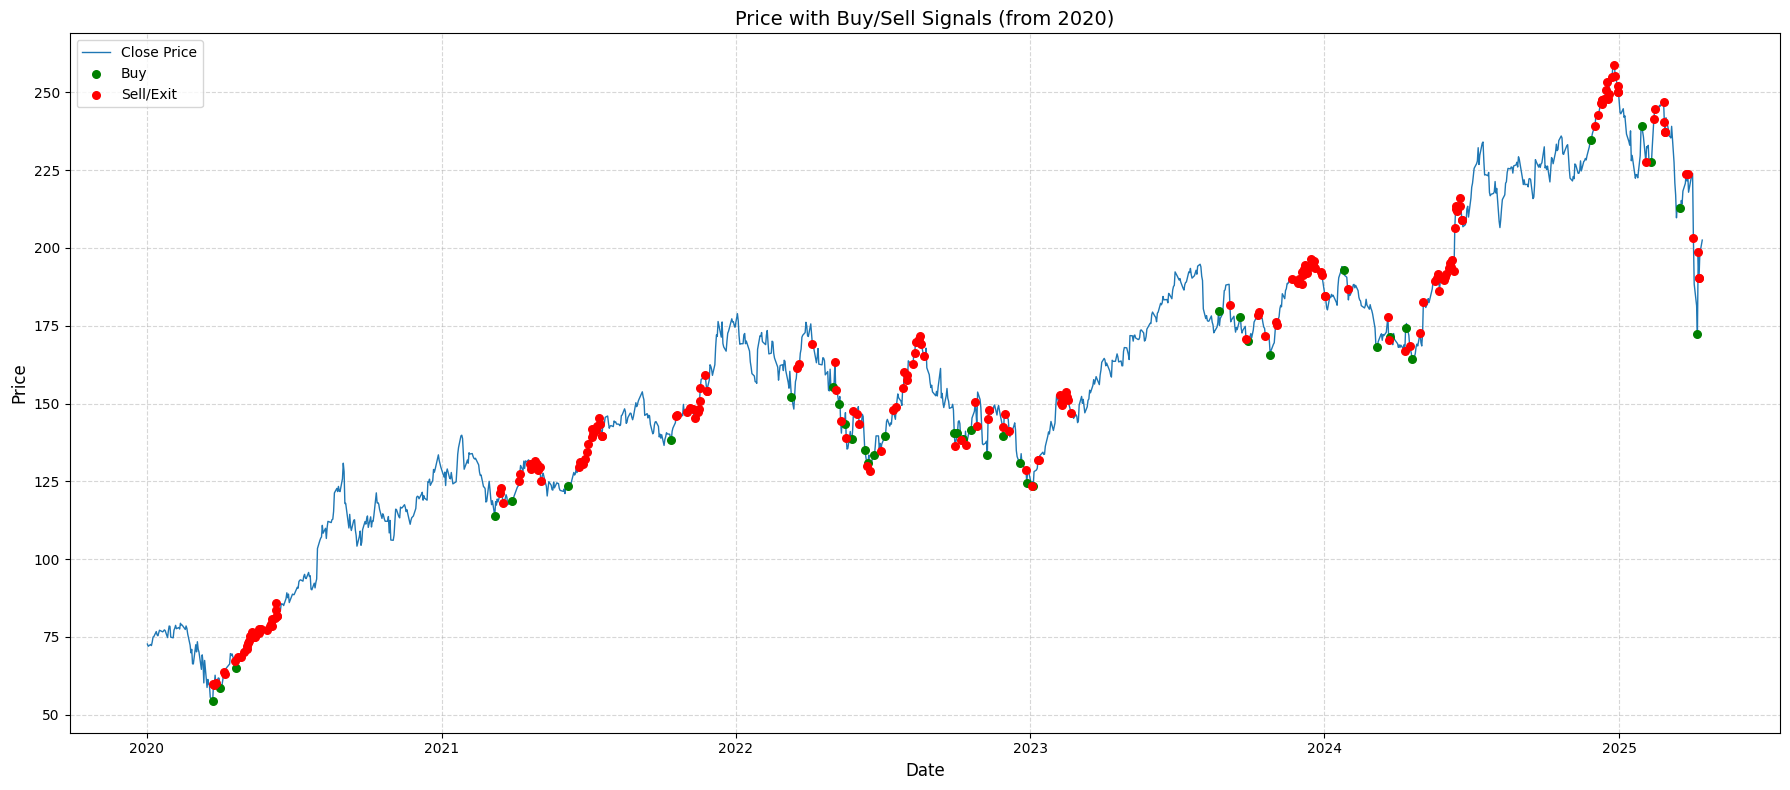

In [10]:
import matplotlib.pyplot as plt

# Filter the dataset from 2020 onwards (can't really see the dots if timeframe too big)
filtered_df = df[df.index >= "2020"]
filtered_trades = [t for t in trade_log if t["Date"] >= pd.to_datetime("2020")]

# Prepare signals
buy_trades = [t for t in filtered_trades if "Buy" in t["Action"]]
sell_trades = [t for t in filtered_trades if "Sell" in t["Action"] or "Partial" in t["Action"]]

# Extract details
buy_dates = [t["Date"] for t in buy_trades]
buy_prices = [t["Price"] for t in buy_trades]
sell_dates = [t["Date"] for t in sell_trades]
sell_prices = [t["Price"] for t in sell_trades]

# Plot
plt.figure(figsize=(18, 8))
plt.plot(filtered_df.index, filtered_df["Close"], label="Close Price", linewidth=1)
plt.scatter(buy_dates, buy_prices, color="green", label="Buy", s=30, zorder=3)
plt.scatter(sell_dates, sell_prices, color="red", label="Sell/Exit", s=30, zorder=3)

plt.title("Price with Buy/Sell Signals (from 2020)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed
<ipython-input-31-9d6991c03c56>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sp500 = sp500["Close"].reindex(returns_df.index).fillna(method="ffill")


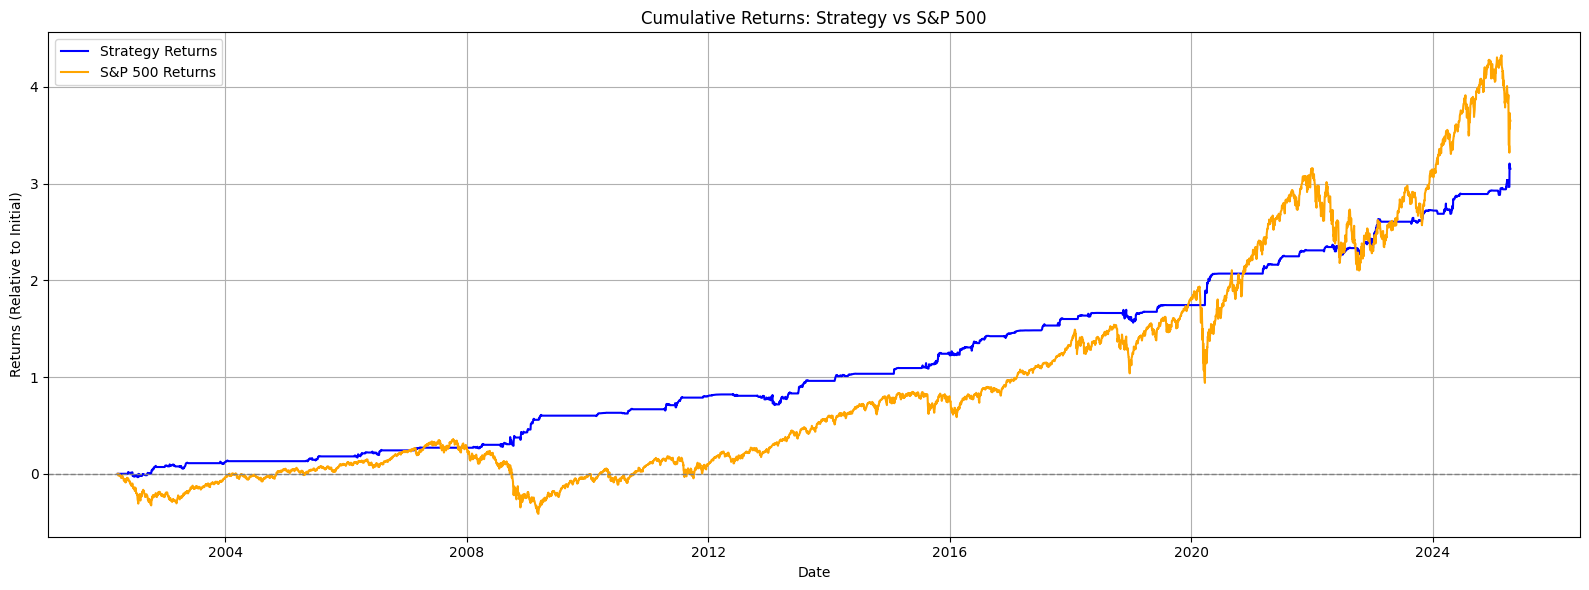

In [31]:
returns_df = combined_df.copy()

# Calculate returns relative to initial capital
initial_value = 100000
returns_df["Returns"] = (returns_df["PortfolioValue"] - initial_value) / initial_value

# Download S&P 500 (ticker: ^GSPC)
sp500 = yf.download("^GSPC", start=combined_df.index.min(), end=combined_df.index.max())

# Align dates and keep only the 'Close' price
sp500 = sp500["Close"].reindex(returns_df.index).fillna(method="ffill")

initial_sp500_price = sp500.iloc[0]
returns_df["SP500_Returns"] = (sp500 - initial_sp500_price) / initial_sp500_price



# Plot returns
plt.figure(figsize=(16, 6))
plt.plot(returns_df.index, returns_df["Returns"], label="Strategy Returns", color="blue")
plt.plot(returns_df.index, returns_df["SP500_Returns"], label="S&P 500 Returns", color="orange")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Cumulative Returns: Strategy vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Returns (Relative to Initial)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


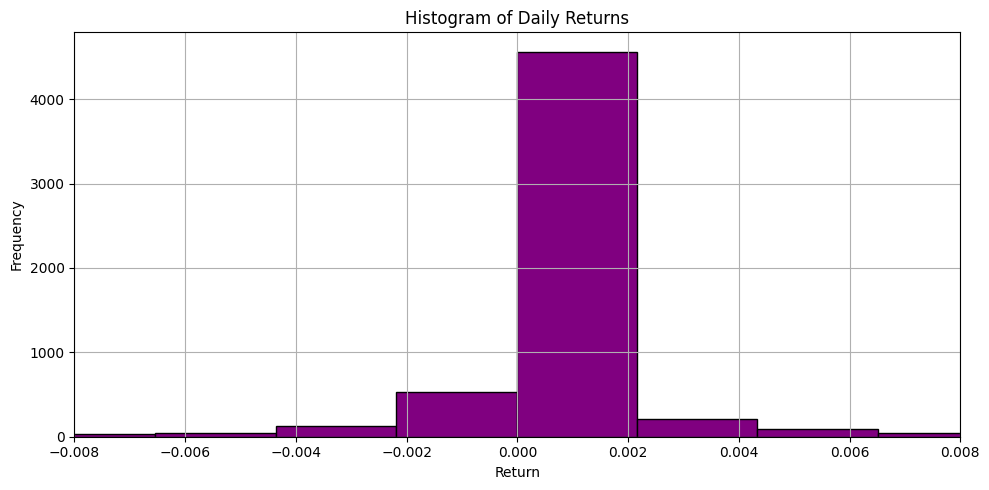

In [22]:
returns_df["Daily_Returns"] = returns_df["PortfolioValue"].pct_change()

plt.figure(figsize=(10, 5))
plt.hist(returns_df["Daily_Returns"].dropna(), bins=50, color="purple", edgecolor="black")
plt.title("Histogram of Daily Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.xlim(-0.008, 0.008)  # Zoom into -0.5% to +0.5%
plt.grid(True)
plt.tight_layout()
plt.show()


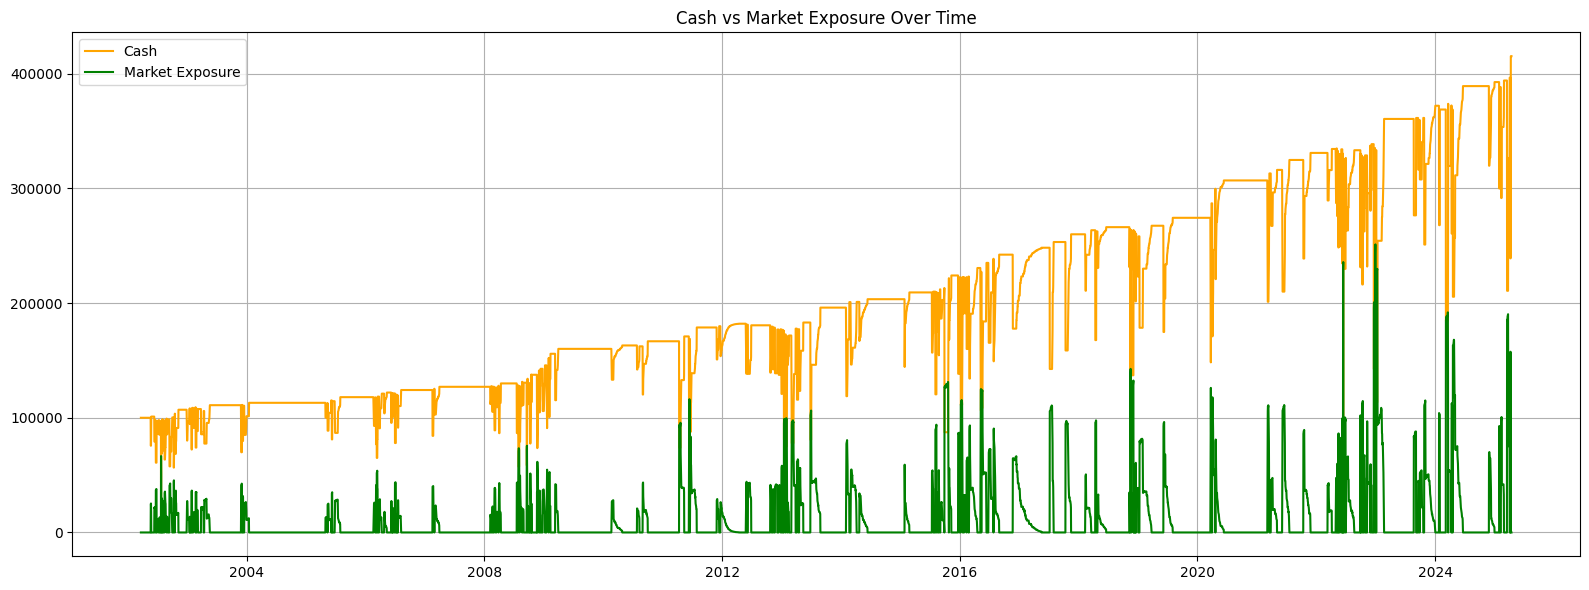

In [18]:
plt.figure(figsize=(16, 6))
plt.plot(combined_df.index, cash_list, label="Cash", color="orange")
plt.plot(combined_df.index, combined_df["UnitsHeld"] * df["Close"], label="Market Exposure", color="green")
plt.title("Cash vs Market Exposure Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
